# Preliminary analysis

The aim here is to find the different factors that have a significant impact on the performances of roaring bitmaps operations.
We only focus on one operation, the union between two roaring bitmaps.

We consider the following (boolean) factors:
  - large1 (resp. large2): true if the first (resp. second) roaring bitmap has (approximately) 2^20 elements, false if it has (approximately) 2^4 elements.
  - dense1 (resp. dense2): true if the elements of the first (resp. second) roaring bitmap are sampled in an interval of size 3*N/2, false if they are sampled in an interval of size 2^6*N (N being the number of elements).
  - copy_on_write: true if the copy on write optimization is used for the two roaring bitmaps (if the optimization is used and the result has a container with the same content than one of the operands' containers, then it uses a reference to this container and no copy is done).
  - run_containers: true if the function `run_optimize` is used before computing the union. This function triggers  a check on all the containers to see if a container conversion is required (from bitset/array to run or from run to bitset/array). Note that run containers may still be used even without this function call.
  - amalgamation: true if the library is amalgamated before the compilation. This means that all the *.c (resp. *.h) files are concatenated into a single roaring.c file (resp. roaring.h). This may help the compiler to perform better optimizations.
  - gcc_optimization: true if the library as well as the test code is compiled with `-O3` option, false it they are compiled with `-O0` option.
  - avx_enabled: true if AVX instructions are used (vector instructions, e.g. to perform in parallel an addition on eight 32 bits integers).

All results of this section are in the file `preliminary_results.csv`. They have been generated with the following command:
```bash
./preliminary_runner.py -n 1024 results.csv
```

It runs 1024 experiments. For each experiment, every factor is randomly set to true or false with equal probability.

In [1]:
library(ggplot2)

## First try: considering all variables at once

In [2]:
all_results <- read.csv("preliminary_results.csv")

In [3]:
all_results_aov <- aov(time~(large1+large2+dense1+dense2+copy_on_write+run_containers+amalgamation+gcc_optimization+avx_enabled)^2, data=all_results)
summary(all_results_aov)

                                 Df   Sum Sq   Mean Sq F value   Pr(>F)    
large1                            1 0.000737 0.0007369 137.730  < 2e-16 ***
large2                            1 0.000738 0.0007382 137.965  < 2e-16 ***
dense1                            1 0.000672 0.0006724 125.677  < 2e-16 ***
dense2                            1 0.000668 0.0006683 124.896  < 2e-16 ***
copy_on_write                     1 0.000020 0.0000204   3.813   0.0511 .  
run_containers                    1 0.000000 0.0000001   0.011   0.9148    
amalgamation                      1 0.000002 0.0000016   0.296   0.5864    
gcc_optimization                  1 0.000224 0.0002244  41.948 1.48e-10 ***
avx_enabled                       1 0.000002 0.0000023   0.423   0.5154    
large1:large2                     1 0.000561 0.0005611 104.872  < 2e-16 ***
large1:dense1                     1 0.000674 0.0006736 125.887  < 2e-16 ***
large1:dense2                     1 0.000524 0.0005243  97.985  < 2e-16 ***
large1:copy_

In this first AOV, we observe that the sizes of the sets as well as their densities have a huge impact on the performance of the union. The use of the GCC optimization is also very significative.

The other variables however do not seem to have any impact.

However, we should check if the hypothesis required to perform an AOV are fulfilled: let us draw the plots.

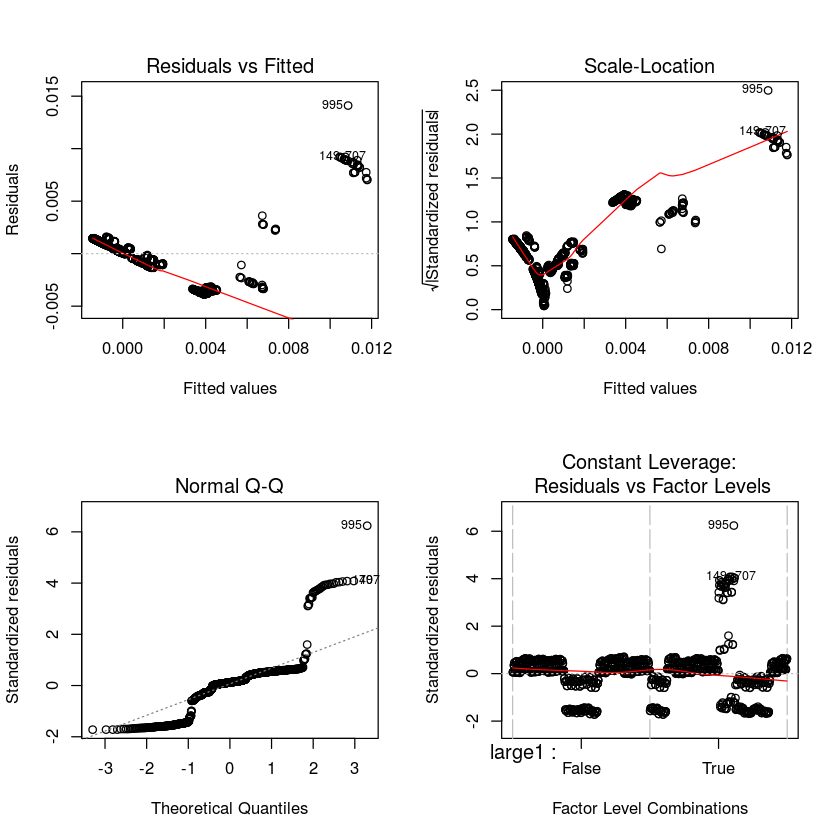

In [4]:
layout(matrix(c(1,2,3,4),2,2))
plot(all_results_aov)

The plots are terrible. The two first ones show that the residuals are not uniformly distributed. They are more spread for large fit values than for small ones, which is a sign of non-constant variance. Also, they are not distributed around a flat line centred on zero, but rather draw a curvilinear plot: our model is not well suited.

Finally, the Q-Q plot shows that the residuals do not follow a Normal distribution.

In [5]:
print(var(all_results[all_results["large1"] == "True" & all_results["large2"] == "True",]$time))
print(var(all_results[all_results["large1"] == "False" & all_results["large2"] == "False",]$time))
print(var(all_results[all_results["dense1"] == "True" & all_results["dense2"] == "True",]$time))
print(var(all_results[all_results["dense1"] == "False" & all_results["dense2"] == "False",]$time))


[1] 4.150348e-05
[1] 2.514512e-11
[1] 5.044169e-09
[1] 4.212937e-05


This confirm the heteroscedasticity: the variance of the results is several orders of magniture higher for large and non-dense datasets than for non-large and dense ones.

We will therefore apply the AOV by fixing these variables to a given value.

## Large and dense datasets

In [6]:
large_dense <- all_results[all_results["large1"]=="True" & all_results["large2"]=="True" & all_results["dense1"]=="True" & all_results["dense2"]=="True",]
large_dense_aov <- aov(time~(copy_on_write+run_containers+amalgamation+gcc_optimization+avx_enabled)^2, data=large_dense)
summary(large_dense_aov)

                                Df    Sum Sq   Mean Sq  F value   Pr(>F)    
copy_on_write                    1 0.000e+00 0.000e+00    0.123 0.727169    
run_containers                   1 3.000e-10 3.000e-10    1.040 0.312825    
amalgamation                     1 1.000e-09 1.000e-09    4.020 0.050620 .  
gcc_optimization                 1 3.207e-07 3.207e-07 1274.649  < 2e-16 ***
avx_enabled                      1 4.900e-09 4.900e-09   19.547  5.6e-05 ***
copy_on_write:run_containers     1 0.000e+00 0.000e+00    0.198 0.658179    
copy_on_write:amalgamation       1 2.000e-10 2.000e-10    0.844 0.362934    
copy_on_write:gcc_optimization   1 0.000e+00 0.000e+00    0.072 0.789461    
copy_on_write:avx_enabled        1 1.000e-10 1.000e-10    0.455 0.503307    
run_containers:amalgamation      1 0.000e+00 0.000e+00    0.166 0.685319    
run_containers:gcc_optimization  1 1.000e-10 1.000e-10    0.529 0.470744    
run_containers:avx_enabled       1 0.000e+00 0.000e+00    0.019 0.891192    

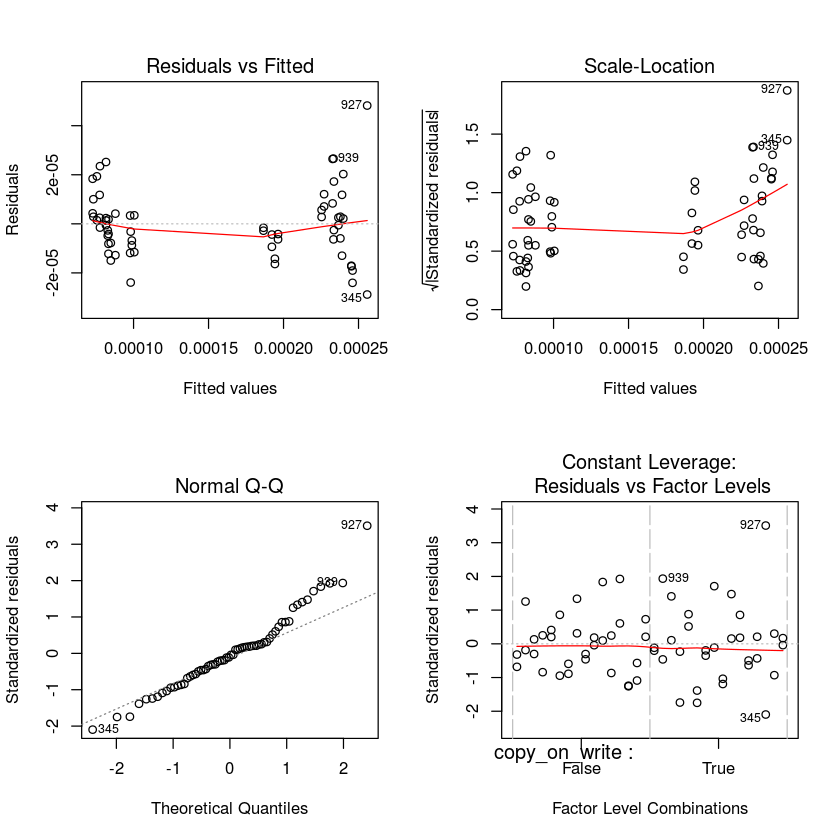

In [7]:
layout(matrix(c(1,2,3,4),2,2))
plot(large_dense_aov)

The plots look more “conform” here. There is nearly no pattern for the residuals vs fitted values: the points are uniformly distributed around the x axis. The QQ-plot is also almost a line.

The summary shows that, for large and dense datasets, the factors with a significant impact are `gcc_optimization` and `avx_enabled`. Also, the impact of the `amalgamation` factor seems to be correlated with `gcc_optimization` and `avx_enabled`.

## Large and non-dense datasets

In [8]:
large_nondense <- all_results[all_results["large1"]=="True" & all_results["large2"]=="True" & all_results["dense1"]=="False" & all_results["dense2"]=="False",]
large_nondense_aov <- aov(time~(copy_on_write+run_containers+amalgamation+gcc_optimization+avx_enabled)^2, data=large_nondense)
summary(large_nondense_aov)

                                Df   Sum Sq  Mean Sq  F value   Pr(>F)    
copy_on_write                    1 0.000000 0.000000    0.227 0.635585    
run_containers                   1 0.000000 0.000000    0.214 0.645797    
amalgamation                     1 0.000024 0.000024   13.576 0.000582 ***
gcc_optimization                 1 0.003431 0.003431 1966.385  < 2e-16 ***
avx_enabled                      1 0.000035 0.000035   19.809 5.08e-05 ***
copy_on_write:run_containers     1 0.000001 0.000001    0.589 0.446396    
copy_on_write:amalgamation       1 0.000001 0.000001    0.440 0.510295    
copy_on_write:gcc_optimization   1 0.000000 0.000000    0.093 0.761424    
copy_on_write:avx_enabled        1 0.000000 0.000000    0.231 0.633038    
run_containers:amalgamation      1 0.000001 0.000001    0.569 0.454379    
run_containers:gcc_optimization  1 0.000000 0.000000    0.207 0.651143    
run_containers:avx_enabled       1 0.000000 0.000000    0.101 0.751779    
amalgamation:gcc_optimiza

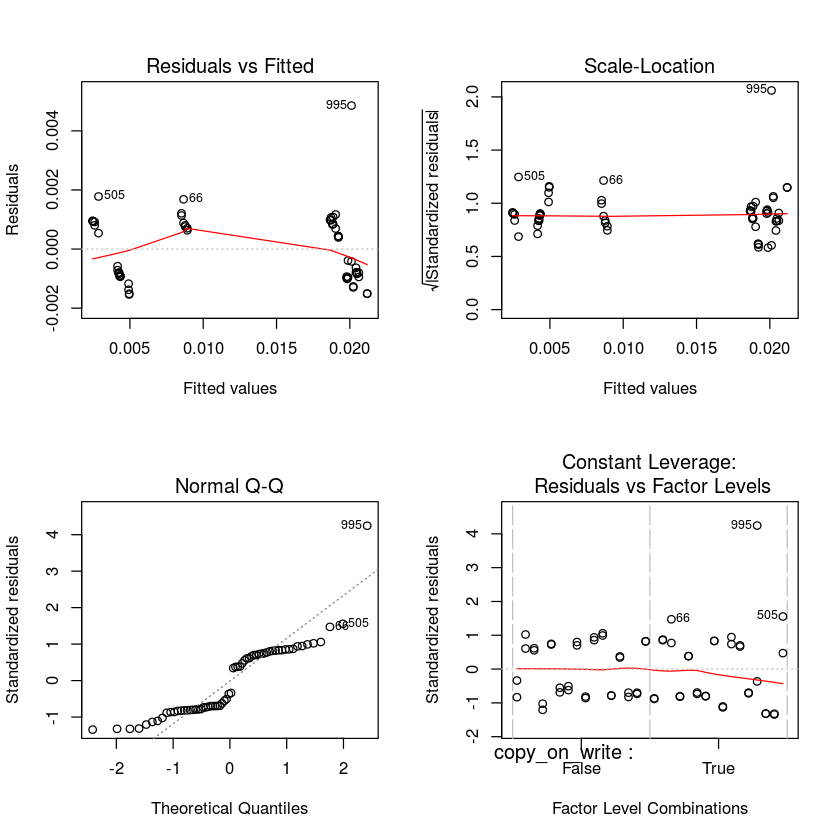

In [9]:
layout(matrix(c(1,2,3,4),2,2))
plot(large_nondense_aov)

The plots are here better than the first one, but not perfect. The points are still not uniformly distributed on the fitted values vs residuals plot, and the QQ-plot is not a straight line.

The summary shows that again, the factors `gcc_optimization`, `avx_enabled` and `amalgamation` have a significant impact on the performances.

## Large and one-dense datasets

Here, one and only one of the datasets is `dense`.

In [10]:
large_onedense <- all_results[all_results["large1"]=="True" & all_results["large2"]=="True" & (all_results["dense1"]=="True" | all_results["dense2"]=="True") & (all_results["dense1"]=="False" | all_results["dense2"]=="False"),]
large_onedense_aov <- aov(time~(copy_on_write+run_containers+amalgamation+gcc_optimization+avx_enabled)^2, data=large_onedense)
summary(large_onedense_aov)

                                 Df    Sum Sq   Mean Sq  F value   Pr(>F)    
copy_on_write                     1 1.862e-05 1.862e-05 9412.393  < 2e-16 ***
run_containers                    1 6.000e-09 6.000e-09    3.107 0.080701 .  
amalgamation                      1 4.600e-08 4.600e-08   23.073 4.87e-06 ***
gcc_optimization                  1 9.100e-08 9.100e-08   46.214 5.41e-10 ***
avx_enabled                       1 3.300e-08 3.300e-08   16.781 7.96e-05 ***
copy_on_write:run_containers      1 1.000e-09 1.000e-09    0.618 0.433297    
copy_on_write:amalgamation        1 0.000e+00 0.000e+00    0.161 0.689252    
copy_on_write:gcc_optimization    1 7.000e-09 7.000e-09    3.599 0.060405 .  
copy_on_write:avx_enabled         1 0.000e+00 0.000e+00    0.206 0.650873    
run_containers:amalgamation       1 4.000e-09 4.000e-09    2.091 0.150958    
run_containers:gcc_optimization   1 1.000e-09 1.000e-09    0.672 0.414150    
run_containers:avx_enabled        1 0.000e+00 0.000e+00    0.034

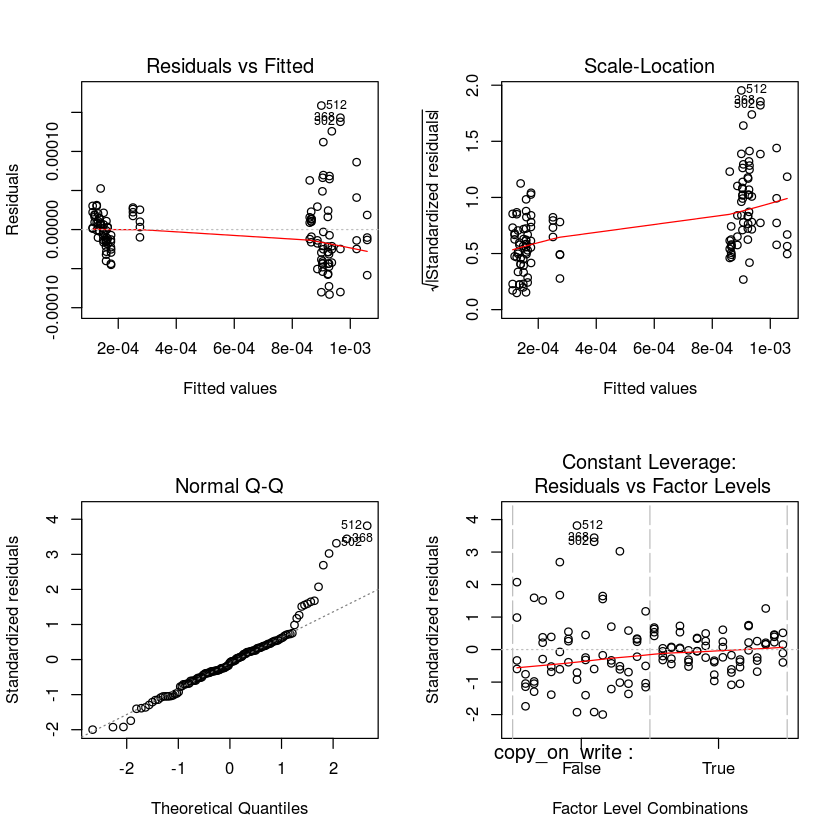

In [11]:
layout(matrix(c(1,2,3,4),2,2))
plot(large_onedense_aov)

Again, the plots are not great, but they are still better than for the general case.

With the summary, we see that for this case, the factor `copy_on_write` is by far the more impactful (F value several orders of magnitude greater than the other significant factors). The other important factors are `amalgamation`, `gcc_optimization` and `avx_enabled`. The factor `run_container` has also a small impact.

## Non-large datasets

In [12]:
nonlarge <- all_results[all_results["large1"]=="False" & all_results["large2"]=="False",]
nonlarge_aov <- aov(time~(copy_on_write+run_containers+amalgamation+gcc_optimization+avx_enabled)^2, data=nonlarge)
summary(nonlarge_aov)

                                 Df    Sum Sq   Mean Sq F value  Pr(>F)   
copy_on_write                     1 3.100e-11 3.103e-11   1.322 0.25139   
run_containers                    1 3.700e-11 3.693e-11   1.573 0.21097   
amalgamation                      1 1.860e-10 1.856e-10   7.905 0.00534 **
gcc_optimization                  1 1.620e-10 1.619e-10   6.899 0.00918 **
avx_enabled                       1 1.000e-11 9.990e-12   0.426 0.51481   
copy_on_write:run_containers      1 1.600e-11 1.643e-11   0.700 0.40368   
copy_on_write:amalgamation        1 1.700e-11 1.714e-11   0.730 0.39362   
copy_on_write:gcc_optimization    1 1.000e-12 7.500e-13   0.032 0.85835   
copy_on_write:avx_enabled         1 1.800e-11 1.792e-11   0.763 0.38315   
run_containers:amalgamation       1 4.000e-12 4.360e-12   0.186 0.66706   
run_containers:gcc_optimization   1 2.400e-11 2.388e-11   1.017 0.31417   
run_containers:avx_enabled        1 5.900e-11 5.870e-11   2.501 0.11511   
amalgamation:gcc_optimiza

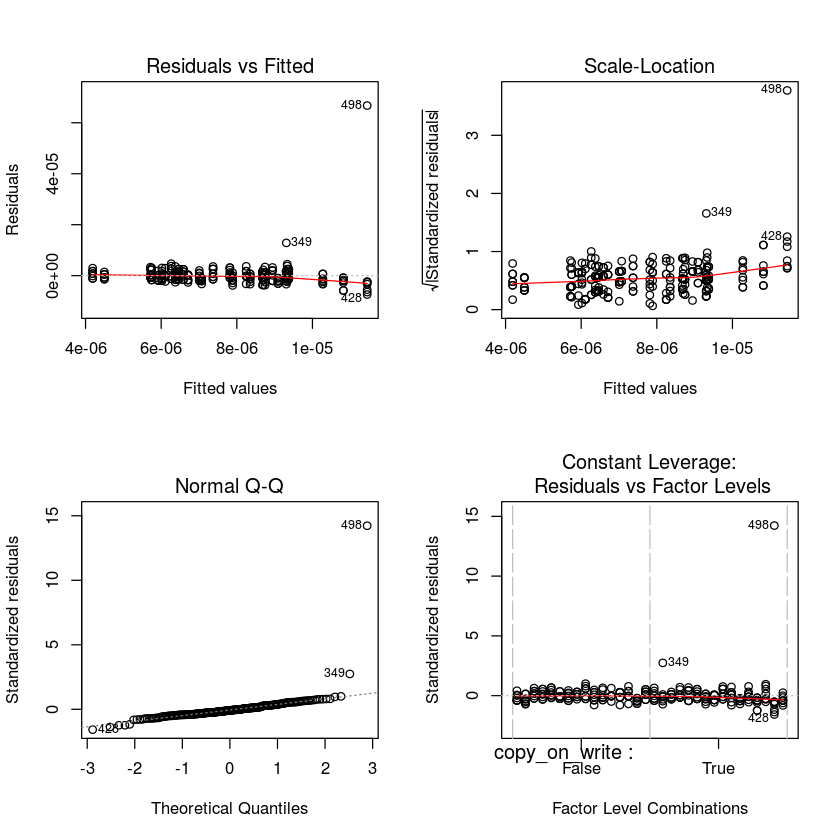

In [13]:
layout(matrix(c(1,2,3,4),2,2))
plot(nonlarge_aov)

The plots are great, except for two outliers. The points are uniformly distributed around the x axis on the two first plots, and the QQ-plot is a straight line.

The summary shows that the factors `gcc_optimization` and `avx_enabled` have a significant impact on the performances.

## Conclusion

A first AOV on all the factors showed that our data does not fulfill the hypothesis: the variance of the time is not constant.

To overcome this, we fixed the “problematic” variables, i.e. the sizes and the densities of the roaring bitmaps.

Without surprise, the factor `gcc_optimization` is always very significant.

For large roaring bitmaps, the factor `avx_enabled` is also always significant. The factor `amalgamation` is important if at least one of the roaring bitmaps is non dense, and the factor `copy_on_write` is very important if one and only one of them is dense.

For small roaring bitmaps, the only important factors are `amalgamation` and `gcc_optimization`.